In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./datasets/train.csv")

In [4]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
print(df.dtypes)
df.describe()

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
# How many null values are there
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

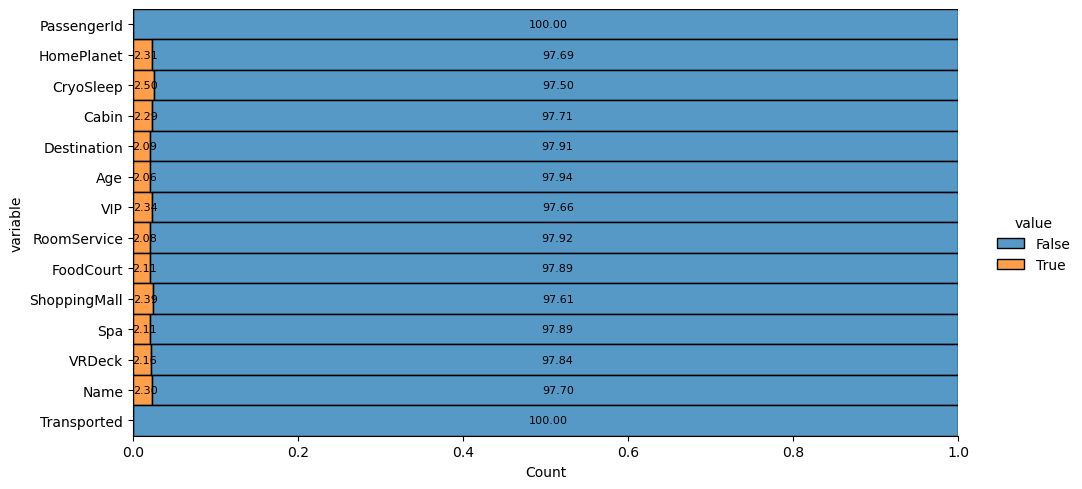

In [18]:
# seeing the null values proportion
fg = df.isnull().melt().pipe(
    lambda df: (
        sns.displot(
            data=df,
            y="variable",
            hue="value",
            aspect=2,
            multiple = "fill"
        )
    )
)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates value and adds an empty string so 0 value bars don't have a number
        labels = [f'{w:.2f}' if (w := (v.get_width())*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=8, rotation=0, padding=2)
    ax.margins(x=0.2)

plt.show()

The  null values represents a very low percentage of the data (around 2%)
_____________________

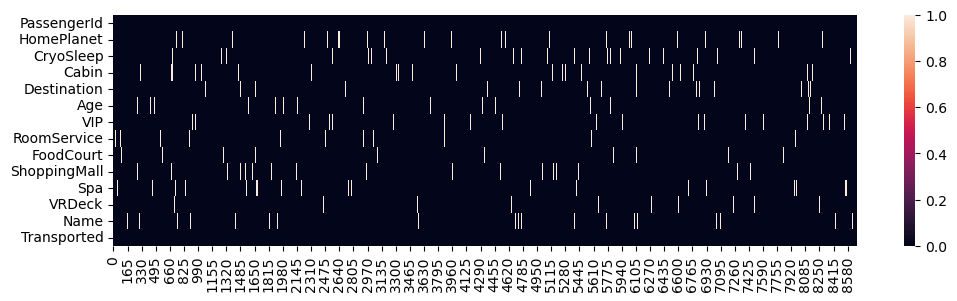

In [19]:
# See the null values on the whole dataset
plt.figure(figsize=(12, 3))

(
    df.isnull()
    .transpose()
    .pipe(
        lambda df: (
            sns.heatmap(
                data = df
            )
        )
    )
)
plt.show()

Here we can see that most of the null data is distributed into diffetent rows or records.
___________

In [20]:
# Creating a new variable without null values
passengers = df.dropna()
passengers.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

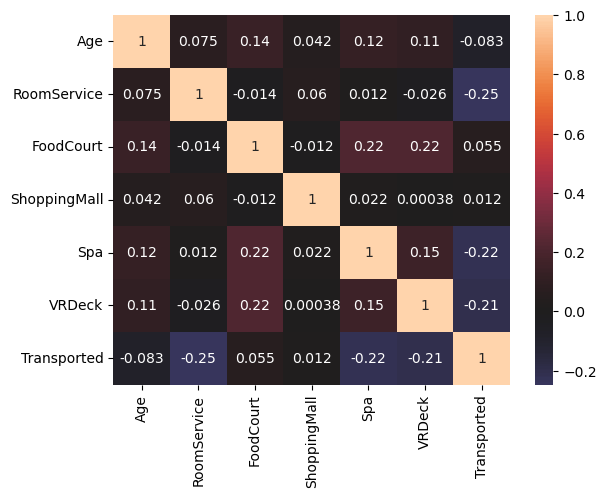

In [24]:
corr = passengers.corr()
sns.heatmap(data= corr, center=0, annot=True)
plt.show()